In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, Normalize
from mlx_lm import load, generate

In [11]:
# Load the coral data
coral_data = pd.read_csv('deep_sea_corals.csv', usecols=['latitude', 'longitude', 'DepthInMeters'])
coral_data = coral_data.drop(0)

# Ensure the columns are the correct dtype
coral_data['latitude'] = pd.to_numeric(coral_data['latitude'], errors='coerce')
coral_data['longitude'] = pd.to_numeric(coral_data['longitude'], errors='coerce')
coral_data['DepthInMeters'] = pd.to_numeric(coral_data['DepthInMeters'], errors='coerce')

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_2101/119423695.py:2: DtypeWarning: Columns (7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  coral_data = pd.read_csv('deep_sea_corals.csv', usecols=['latitude', 'longitude', 'DepthInMeters'])


In [12]:
# Drop rows with invalid data
coral_data = coral_data.dropna(subset=['latitude', 'longitude', 'DepthInMeters'])

# Create a GeoDataFrame for coral data
coral_gdf = gpd.GeoDataFrame(coral_data, geometry=gpd.points_from_xy(coral_data.longitude, coral_data.latitude))

# Load the temperature data without headers
temperature_data = pd.read_csv('temperature.CSV', header=None)

# Load the custom colormap from the .act file
def read_act_file(file_path):
    with open(file_path, 'rb') as f:
        colors = np.frombuffer(f.read(), dtype=np.uint8)
    colors = colors.reshape((-1, 3)) / 255.0  # Normalize the colors
    return ListedColormap(colors)

custom_cmap = read_act_file('sst_35.act')

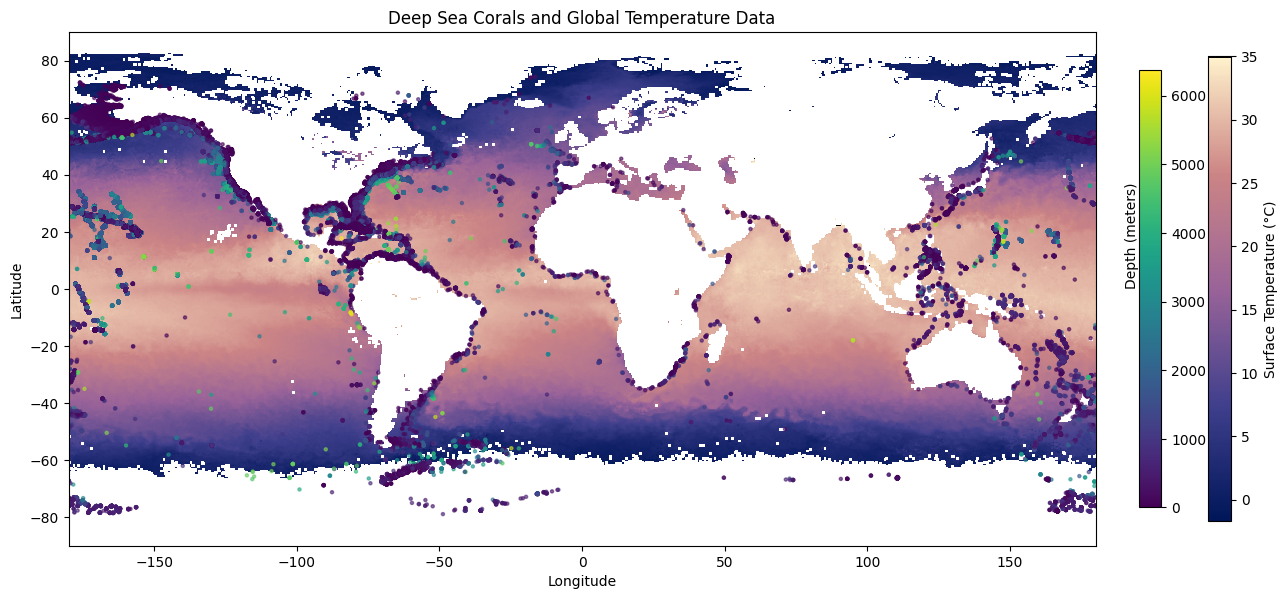

In [21]:
# Replace 99999.0 with NaN
temperature_data.replace(99999.0, np.nan, inplace=True)

# Normalize the colormap to enhance brightness
norm = Normalize(vmin=np.nanmin(temperature_data), vmax=np.nanmax(temperature_data))

# Plot the temperature data as a heatmap using the custom colormap
fig, ax = plt.subplots(figsize=(15, 10))
cax = ax.imshow(temperature_data, cmap=custom_cmap, alpha=1.0, extent=[-180, 180, -90, 90], norm=norm)

# Add colorbar for temperature data
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Surface Temperature (°C)')

# Plot the coral GeoDataFrame with color based on depth
coral_plot = coral_gdf.plot(ax=ax, column='DepthInMeters', cmap='viridis', markersize=5, alpha=0.6)

# Create a custom legend for the coral data
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=coral_gdf['DepthInMeters'].min(), vmax=coral_gdf['DepthInMeters'].max()))
sm._A = []
cbar_coral = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar_coral.set_label('Depth (meters)', labelpad=0, ha='left')
cbar_coral.ax.yaxis.set_label_position('left')
cbar_coral.ax.yaxis.set_ticks_position('right')

# Ensure both colorbars are the same size and have labels
cbar_coral.ax.tick_params(labelsize=cbar.ax.yaxis.get_ticklabels()[0].get_fontsize())

plt.title('Deep Sea Corals and Global Temperature Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Data Interpolation

AttributeError: 'Axes3D' object has no attribute 'w_xaxis'

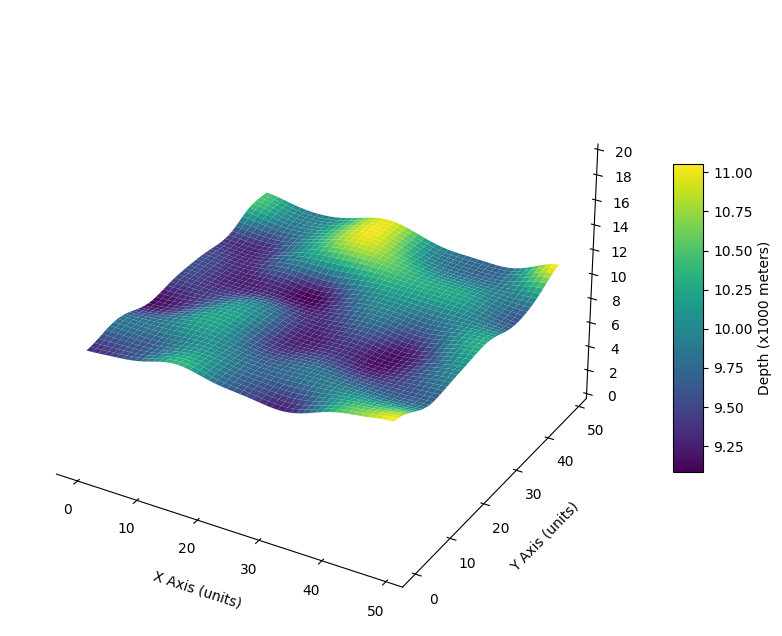

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Load the depth_matrix from npy file
depth_matrix = np.load('depth_matrix.npy')

# Apply a stronger Gaussian filter to smooth the surface
depth_matrix = gaussian_filter(depth_matrix, sigma=3)

# Scale the depth values to avoid decimals
scale_factor = 1000
depth_matrix *= scale_factor

# Create a meshgrid for plotting
x = np.linspace(0, 49, 50)
y = np.linspace(0, 49, 50)
x, y = np.meshgrid(x, y)

# Create a figure for the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface (plane plot)
surf = ax.plot_surface(x, y, depth_matrix, cmap='viridis', edgecolor='none')

# Add a colorbar for the surface plot
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)  # Adjusted aspect for a thinner color bar
cbar.set_label('Depth (x1000 meters)')

# Set z-axis limits to make changes look smaller
ax.set_zlim(0, 20)  # Adjust this range to be larger than the depth values to flatten the appearance

# Set labels and title
ax.set_xlabel('X Axis (units)', labelpad=10)
ax.set_ylabel('Y Axis (units)', labelpad=10)

# Set axis ticks to integers
ax.zaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Remove the background grid
ax.grid(False)

# Make the background panes transparent
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

# Remove the axis lines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # transparent
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # transparent
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # transparent

# Show plot
plt.show()


In [111]:
import numpy as np

# Load the depth matrix from the npy file
depth_matrix = np.load('depth_matrix.npy')

# Define the region to elevate (bottom central side of the matrix)
region_size = 10
center_x = depth_matrix.shape[1] // 2
bottom_y = depth_matrix.shape[0] - region_size

# Manually adjust the matrix values for the coral region
depth_matrix[bottom_y:, center_x - region_size//2:center_x + region_size//2] = 0.01

# Save the modified matrix back to a new npy file
np.save('depth_matrix_with_coral_manual.npy', depth_matrix)


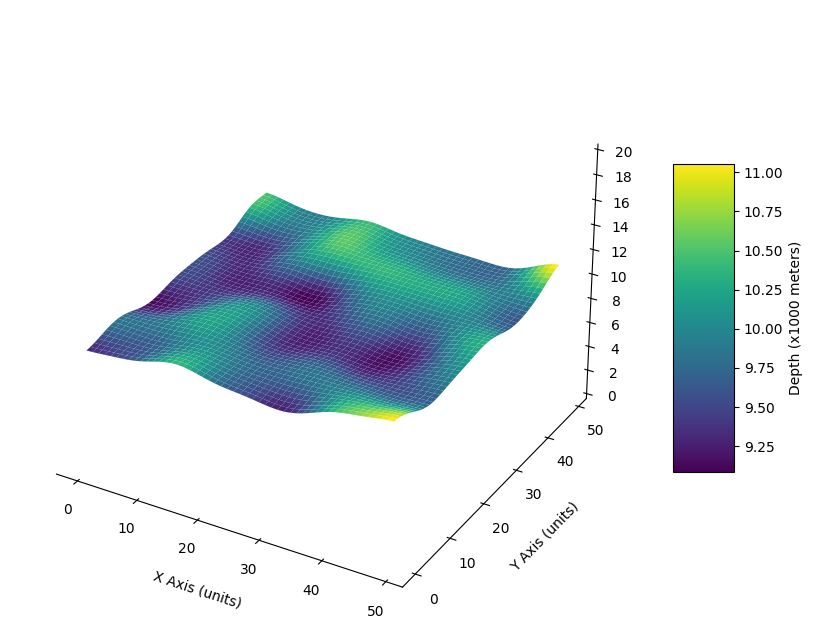

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

# Load the depth_matrix from npy file
depth_matrix = np.load('depth_matrix_with_coral_manual.npy')

# Apply a stronger Gaussian filter to smooth the surface
depth_matrix = gaussian_filter(depth_matrix, sigma=3)

# Scale the depth values to avoid decimals
scale_factor = 1000
depth_matrix *= scale_factor

# Create a meshgrid for plotting
x = np.linspace(0, 49, 50)
y = np.linspace(0, 49, 50)
x, y = np.meshgrid(x, y)

# Create a figure for the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface (plane plot)
surf = ax.plot_surface(x, y, depth_matrix, cmap='viridis', edgecolor='none')

# Add a colorbar for the surface plot
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Depth (x1000 meters)')

# Set z-axis limits to make changes look smaller
ax.set_zlim(0, 20)  # Adjust this range to be larger than the depth values to flatten the appearance

# Set labels and title
ax.set_xlabel('X Axis (units)', labelpad=10)
ax.set_ylabel('Y Axis (units)', labelpad=10)

# Set axis ticks to integers
ax.zaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Remove the background grid
ax.grid(False)

# Make the background panes transparent
ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)

# Show plot
plt.show()
